# Serengeti Animal Detection: A Comparative Study of CNN and ViT Architectures

This notebook implements and compares three deep learning approaches for wildlife detection and classification on the Serengeti dataset:

1. **Basic CNN** - A custom convolutional neural network with classification and bounding box heads
2. **Transfer Learning CNN** - EfficientNetB0 backbone with custom heads  
3. **Vision Transformer (ViT)** - HuggingFace ViT backbone with custom heads (PyTorch)

## Table of Contents
1. [Setup & Imports](#setup)
2. [Utility Functions](#utilities)
3. [Data Acquisition](#data-acquisition)
4. [Data Exploration](#data-exploration)
5. [Data Preprocessing](#data-preprocessing)
6. [Model 1: Basic CNN](#basic-cnn)
7. [Model 2: Transfer Learning CNN (EfficientNetB0)](#transfer-cnn)
8. [Model 3: Vision Transformer (ViT)](#vit)
9. [Model Comparison](#comparison)
10. [Conclusions](#conclusions)

<a name="setup"></a>
## 1. Setup & Imports

Install required packages and import all necessary libraries for TensorFlow (CNN models) and PyTorch (ViT model).

In [2]:
# =============================================================================
# IMPORTS - All libraries needed for the project
# =============================================================================

# Standard libraries
import os
import subprocess
import json

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

# Scikit-learn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# TensorFlow/Keras (for CNN models)
import tensorflow as tf
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import (
    Input, Dense, Dropout, Flatten, Activation, Conv2D,
    MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
)
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications import EfficientNetB0

# PyTorch (for ViT model)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import ViTModel

# Image handling
from PIL import Image, ImageFile
from tqdm import tqdm
import kagglehub

# Allow loading truncated images (for corrupted file handling)
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Set visualization theme
sns.set_theme()

print("✓ All imports successful!")
print(f"✓ TensorFlow version: {tf.__version__}")
print(f"✓ PyTorch version: {torch.__version__}")

✓ All imports successful!
✓ TensorFlow version: 2.19.0
✓ PyTorch version: 2.9.0+cu126


<a name="utilities"></a>
## 2. Utility Functions

Common functions used across all models for data loading, preprocessing, and visualization.

In [5]:
# =============================================================================
# TENSORFLOW DATASET BUILDERS (for CNN models)
# =============================================================================

def _create_load_and_preprocess_fn(image_size):
    """Create a load_and_preprocess function with the specified image size."""

    def load_and_preprocess(path, label, bbox=None):
        image_bytes = tf.io.read_file(path)
        is_jpeg = tf.image.is_jpeg(image_bytes)

        def invalid():
            return (
                tf.zeros(image_size + (3,)),
                {"class_output": -1, "bbox_output": tf.zeros((4,))},
                path,
            )

        def valid():
            image = tf.image.decode_jpeg(image_bytes, channels=3)

            # Get original dimensions for bbox normalization
            orig_h = tf.cast(tf.shape(image)[0], tf.float32)
            orig_w = tf.cast(tf.shape(image)[1], tf.float32)

            # Resize to target size
            image = tf.image.resize(image, image_size)
            image = tf.image.convert_image_dtype(image, tf.float32)

            # Normalize bounding box relative to original image dimensions
            if bbox is not None:
                bbox_norm = bbox / [orig_w, orig_h, orig_w, orig_h]
            else:
                bbox_norm = tf.zeros((4,))

            bbox_norm = tf.cast(bbox_norm, tf.float32)
            return (image, {"class_output": label, "bbox_output": bbox_norm}, path)

        return tf.cond(is_jpeg, valid, invalid)

    return load_and_preprocess


def build_tf_dataset(filepaths, labels, bbox_array, image_size):
    """Build a TensorFlow dataset from file paths, labels, and bounding boxes."""
    load_and_preprocess = _create_load_and_preprocess_fn(image_size)

    ds = tf.data.Dataset.from_tensor_slices((filepaths, labels, bbox_array))
    ds = ds.map(load_and_preprocess, num_parallel_calls=AUTOTUNE)
    ds = ds.filter(lambda image, labels, path: labels["class_output"] != -1)
    ds = ds.apply(tf.data.Dataset.ignore_errors)
    return ds


def split_dataset(ds, total_size, train_frac=0.8, val_frac=0.1, batch_size=32, shuffle_buffer=500, seed=SEED):
    """Split a dataset into train, validation, and test sets."""
    train_size = int(train_frac * total_size)
    val_size = int(val_frac * total_size)

    raw_ds = ds.shuffle(shuffle_buffer, seed=seed)

    train_raw = raw_ds.take(train_size)
    val_raw = raw_ds.skip(train_size).take(val_size)
    test_raw = raw_ds.skip(train_size + val_size)

    train_ds = train_raw.map(lambda x, y, p: (x, y), num_parallel_calls=AUTOTUNE).batch(batch_size).prefetch(AUTOTUNE)
    val_ds = val_raw.map(lambda x, y, p: (x, y), num_parallel_calls=AUTOTUNE).batch(batch_size).prefetch(AUTOTUNE)
    test_ds = test_raw.map(lambda x, y, p: (x, y), num_parallel_calls=AUTOTUNE).batch(batch_size).prefetch(AUTOTUNE)

    return {
        "train": train_ds, "val": val_ds, "test": test_ds,
        "train_raw": train_raw, "val_raw": val_raw, "test_raw": test_raw,
    }


print("✓ TensorFlow dataset builders defined")

✓ TensorFlow dataset builders defined


---
## 3. Data Acquisition

Download the dataset from Kaggle and load the labels from Google Drive.

In [8]:
# Load labels from Google Drive (using vit.ipynb approach)
labels_df = load_labels()

print(f"Labels DataFrame shape: {labels_df.shape}")
labels_df.head()

✓ Downloaded labels.csv to labels.csv
Labels DataFrame shape: (9261, 9)


,file_path,animal,sequence,image_path,animal_count,a1,a2,a3,a4
0,1.63-European_Hare/SEQ81358/SEQ81358_IMG_0001.JPG,European_Hare,SEQ81358,SEQ81358_IMG_0001.JPG,1,0,32,2048,1120
1,1.63-European_Hare/SEQ81358/SEQ81358_IMG_0004.JPG,European_Hare,SEQ81358,SEQ81358_IMG_0004.JPG,1,917,769,1118,857
2,1.63-European_Hare/SEQ81062/SEQ81062_IMG_0001.JPG,European_Hare,SEQ81062,SEQ81062_IMG_0001.JPG,1,894,1003,2048,1474
3,1.63-European_Hare/SEQ79517/SEQ79517_IMG_0002.JPG,European_Hare,SEQ79517,SEQ79517_IMG_0002.JPG,1,769,36,1250,819
4,1.63-European_Hare/SEQ79517/SEQ79517_IMG_0003.JPG,European_Hare,SEQ79517,SEQ79517_IMG_0003.JPG,1,556,360,1000,938


In [9]:
# Check for missing values
print("Missing values per column:")
print(labels_df.isnull().sum())
print(f"\nTotal missing values: {labels_df.isnull().sum().sum()}")

Missing values per column:
file_path       0
animal          0
sequence        0
image_path      0
animal_count    0
a1              0
a2              0
a3              0
a4              0
dtype: int64

Total missing values: 0


/tmp/ipython-input-2217622964.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled = df_with_animals.groupby('animal', group_keys=False).apply(


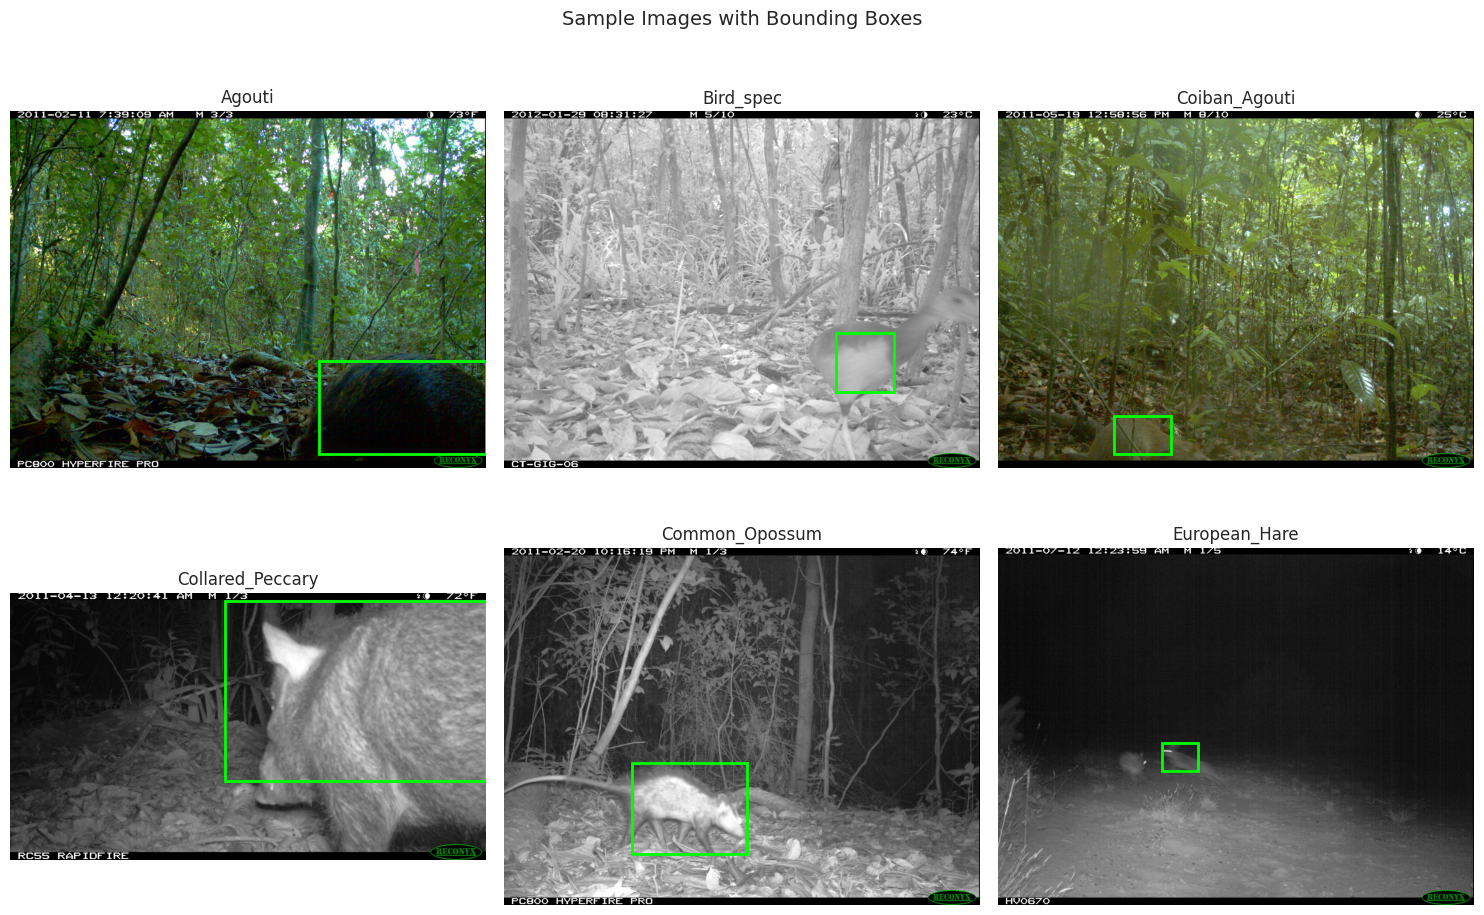

In [11]:
# Display sample images with bounding boxes
# First, set the path base for images
PATH_BASE = "/kaggle/input/serengeti-dataset/Set1/"

def display_sample_images(df, path_base, n_samples=6):
    """Display sample images with bounding boxes from each class."""
    # Filter to only rows with animals
    df_with_animals = df[df["animal_count"] > 0].copy()

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    # Get samples from different classes
    sampled = df_with_animals.groupby('animal', group_keys=False).apply(
        lambda x: x.sample(1, random_state=42)
    ).reset_index(drop=True)
    sampled = sampled.head(n_samples)

    for idx, (ax, (_, row)) in enumerate(zip(axes, sampled.iterrows())):
        try:
            full_path = path_base + row['file_path']
            img = Image.open(full_path)
            ax.imshow(img)

            # Draw bounding box (using a1, a2, a3, a4 columns)
            x1, y1, x2, y2 = row['a1'], row['a2'], row['a3'], row['a4']
            if not np.isnan(x1):  # Only draw if bbox exists
                rect = patches.Rectangle(
                    (x1, y1), x2 - x1, y2 - y1,
                    linewidth=2, edgecolor='lime', facecolor='none'
                )
                ax.add_patch(rect)
            ax.set_title(f"{row['animal']}", fontsize=12)
            ax.axis('off')
        except Exception as e:
            ax.set_title(f"Error: {e}")
            ax.axis('off')

    plt.suptitle('Sample Images with Bounding Boxes', fontsize=14)
    plt.tight_layout()
    plt.show()

display_sample_images(labels_df, PATH_BASE)

In [12]:
# Prepare label data first (to get filepaths for corruption check)
# Filter for images with animals and build full paths
positives = labels_df[labels_df["animal_count"] > 0].copy()
filepaths = np.array([PATH_BASE + fp for fp in positives["file_path"].values])

# Scan for corrupted images
valid_indices, corrupted_indices = find_corrupted_images(filepaths)

print(f"\nTotal images: {len(filepaths)}")
print(f"Valid images: {len(valid_indices)}")
print(f"Corrupted images: {len(corrupted_indices)}")

if len(corrupted_indices) > 0:
    print(f"Removing {len(corrupted_indices)} corrupted images...")
    positives = positives.iloc[valid_indices].reset_index(drop=True)
    filepaths = filepaths[valid_indices]
    print(f"Dataset size after cleaning: {len(filepaths)}")

Scanning for corrupted images...


100%|██████████| 9261/9261 [04:39<00:00, 33.18it/s]


Total images: 9261
Valid images: 9261
Corrupted images: 0


In [14]:
# Split data into train/test sets (stratified by class)
TEST_SPLIT = 0.2
RANDOM_SEED = SEED

train_filepaths, test_filepaths, train_labels, test_labels, train_bboxes, test_bboxes = train_test_split(
    filepaths, labels, bbox_array,
    test_size=TEST_SPLIT,
    random_state=RANDOM_SEED,
    stratify=labels
)

print(f"Training samples: {len(train_filepaths)}")
print(f"Testing samples: {len(test_filepaths)}")

Training samples: 7408
Testing samples: 1853


In [15]:
# Build TensorFlow datasets for CNN models (128x128)
print("Building TensorFlow datasets for CNN models...")

# Create validation split from training data (12.5% of train = ~10% of total)
cnn_train_files, cnn_val_files, cnn_train_labels, cnn_val_labels, cnn_train_bboxes, cnn_val_bboxes = train_test_split(
    train_filepaths, train_labels, train_bboxes,
    test_size=0.125, random_state=RANDOM_SEED, stratify=train_labels
)

# Build raw datasets
cnn_train_ds_raw = build_tf_dataset(cnn_train_files, cnn_train_labels, cnn_train_bboxes, image_size=CNN_IMAGE_SIZE)
cnn_val_ds_raw = build_tf_dataset(cnn_val_files, cnn_val_labels, cnn_val_bboxes, image_size=CNN_IMAGE_SIZE)
cnn_test_ds_raw = build_tf_dataset(test_filepaths, test_labels, test_bboxes, image_size=CNN_IMAGE_SIZE)

# Batch and prefetch
cnn_train_ds = cnn_train_ds_raw.map(lambda x, y, p: (x, y), num_parallel_calls=AUTOTUNE).shuffle(500).batch(CNN_BATCH_SIZE).prefetch(AUTOTUNE)
cnn_val_ds = cnn_val_ds_raw.map(lambda x, y, p: (x, y), num_parallel_calls=AUTOTUNE).batch(CNN_BATCH_SIZE).prefetch(AUTOTUNE)
cnn_test_ds = cnn_test_ds_raw.map(lambda x, y, p: (x, y), num_parallel_calls=AUTOTUNE).batch(CNN_BATCH_SIZE).prefetch(AUTOTUNE)

print(f"✓ CNN Training samples: {len(cnn_train_files)}")
print(f"✓ CNN Validation samples: {len(cnn_val_files)}")
print(f"✓ CNN Test samples: {len(test_filepaths)}")

Building TensorFlow datasets for CNN models...
✓ CNN Training samples: 6482
✓ CNN Validation samples: 926
✓ CNN Test samples: 1853


In [17]:
# Train Basic CNN
CNN_EPOCHS = 50

basic_cnn_history = basic_cnn_model.fit(
    cnn_train_ds,
    epochs=CNN_EPOCHS,
    validation_data=cnn_val_ds
)

Epoch 1/50
    203/Unknown 28s 84ms/step - bbox_output_loss: 152.2180 - bbox_output_mse: 152.2183 - class_output_accuracy: 0.2113 - class_output_loss: 5.3184 - loss: 157.5367

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


203/203 ━━━━━━━━━━━━━━━━━━━━ 34s 112ms/step - bbox_output_loss: 151.6277 - bbox_output_mse: 151.6284 - class_output_accuracy: 0.2119 - class_output_loss: 5.3075 - loss: 156.9360 - val_bbox_output_loss: 0.1250 - val_bbox_output_mse: 0.1250 - val_class_output_accuracy: 0.4492 - val_class_output_loss: 1.8850 - val_loss: 2.0105
Epoch 2/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 15s 67ms/step - bbox_output_loss: 0.1349 - bbox_output_mse: 0.1349 - class_output_accuracy: 0.6009 - class_output_loss: 1.4555 - loss: 1.5904 - val_bbox_output_loss: 0.1420 - val_bbox_output_mse: 0.1420 - val_class_output_accuracy: 0.7171 - val_class_output_loss: 1.0631 - val_loss: 1.2052
Epoch 3/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 15s 68ms/step - bbox_output_loss: 0.1463 - bbox_output_mse: 0.1463 - class_output_accuracy: 0.7862 - class_output_loss: 0.8515 - loss: 0.9978 - val_bbox_output_loss: 0.1124 - val_bbox_output_mse: 0.1124 - val_class_output_accuracy: 0.8164 - val_class_output_loss: 0.7264 - val_loss: 0.8386
Epoch 4/50
203

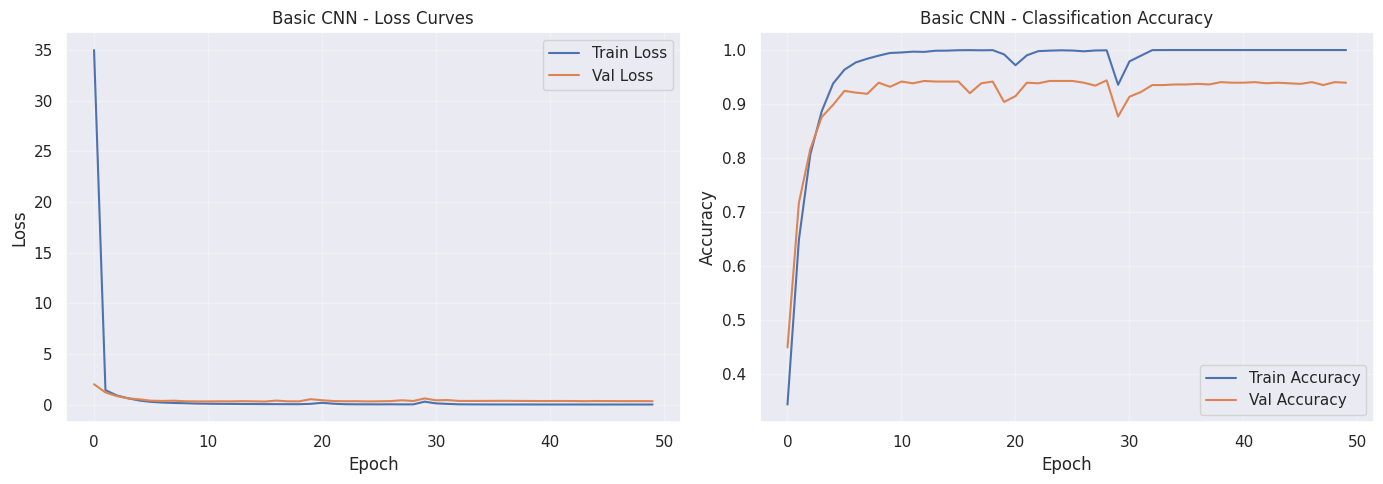

In [19]:
# Plot Basic CNN learning curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
axes[0].plot(basic_cnn_history.history['loss'], label='Train Loss')
axes[0].plot(basic_cnn_history.history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Basic CNN - Loss Curves')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy curves
axes[1].plot(basic_cnn_history.history['class_output_accuracy'], label='Train Accuracy')
axes[1].plot(basic_cnn_history.history['val_class_output_accuracy'], label='Val Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Basic CNN - Classification Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## 7. Model 2: Transfer Learning CNN (EfficientNetB0)

A transfer learning approach using EfficientNetB0 as the backbone with custom heads for classification and bounding box regression. Training proceeds in two phases:
1. **Phase 1**: Freeze backbone, train custom heads only
2. **Phase 2**: Unfreeze top layers of backbone for fine-tuning

In [22]:
# =============================================================================
# PHASE 1: Feature Extraction (Frozen Backbone)
# =============================================================================

print("Phase 1: Training with frozen EfficientNetB0 backbone...")
print("=" * 60)

TRANSFER_EPOCHS_PHASE1 = 10

# Callbacks
phase1_checkpoint = ModelCheckpoint(
    "transfer_cnn_best_phase1.keras",
    monitor="val_class_output_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

phase1_earlystop = EarlyStopping(
    monitor="val_class_output_accuracy",
    patience=5,
    restore_best_weights=True,
    mode="max",
    verbose=1
)

# Train Phase 1
transfer_history_phase1 = transfer_cnn_model.fit(
    cnn_train_ds,
    validation_data=cnn_val_ds,
    epochs=TRANSFER_EPOCHS_PHASE1,
    callbacks=[phase1_checkpoint, phase1_earlystop]
)

print("\n✓ Phase 1 training complete!")

Phase 1: Training with frozen EfficientNetB0 backbone...
Epoch 1/10
    203/Unknown 65s 159ms/step - bbox_output_loss: 0.3048 - bbox_output_mae: 0.4284 - class_output_accuracy: 0.3452 - class_output_loss: 2.1700 - loss: 2.4748

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_class_output_accuracy improved from -inf to 0.64039, saving model to transfer_cnn_best_phase1.keras
203/203 ━━━━━━━━━━━━━━━━━━━━ 94s 301ms/step - bbox_output_loss: 0.3044 - bbox_output_mae: 0.4280 - class_output_accuracy: 0.3458 - class_output_loss: 2.1680 - loss: 2.4723 - val_bbox_output_loss: 0.0838 - val_bbox_output_mae: 0.2312 - val_class_output_accuracy: 0.6404 - val_class_output_loss: 1.2120 - val_loss: 1.2958
Epoch 2/10
200/203 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - bbox_output_loss: 0.1165 - bbox_output_mae: 0.2724 - class_output_accuracy: 0.6204 - class_output_loss: 1.2213 - loss: 1.3379
Epoch 2: val_class_output_accuracy improved from 0.64039 to 0.68898, saving model to transfer_cnn_best_phase1.keras
203/203 ━━━━━━━━━━━━━━━━━━━━ 16s 72ms/step - bbox_output_loss: 0.1163 - bbox_output_mae: 0.2721 - class_output_accuracy: 0.6206 - class_output_loss: 1.2205 - loss: 1.3368 - val_bbox_output_loss: 0.0661 - val_bbox_output_mae: 0.2065 - val_class_output_accuracy: 0.6890 -

In [24]:
# Evaluate Transfer Learning CNN on test set
print("Evaluating Transfer Learning CNN on test set...")
transfer_test_results = transfer_cnn_model.evaluate(cnn_test_ds, verbose=1)

# Store metrics
transfer_cnn_metrics = dict(zip(transfer_cnn_model.metrics_names, transfer_test_results))
print("\nTransfer Learning CNN Test Results:")
for name, value in transfer_cnn_metrics.items():
    print(f"  {name}: {value:.4f}")

Evaluating Transfer Learning CNN on test set...
58/58 ━━━━━━━━━━━━━━━━━━━━ 22s 375ms/step - bbox_output_loss: 0.0640 - bbox_output_mae: 0.1988 - class_output_accuracy: 0.8145 - class_output_loss: 0.5883 - loss: 0.6522

Transfer Learning CNN Test Results:
  loss: 0.6331
  compile_metrics: 0.5671
  class_output_loss: 0.0663
  bbox_output_loss: 0.2040


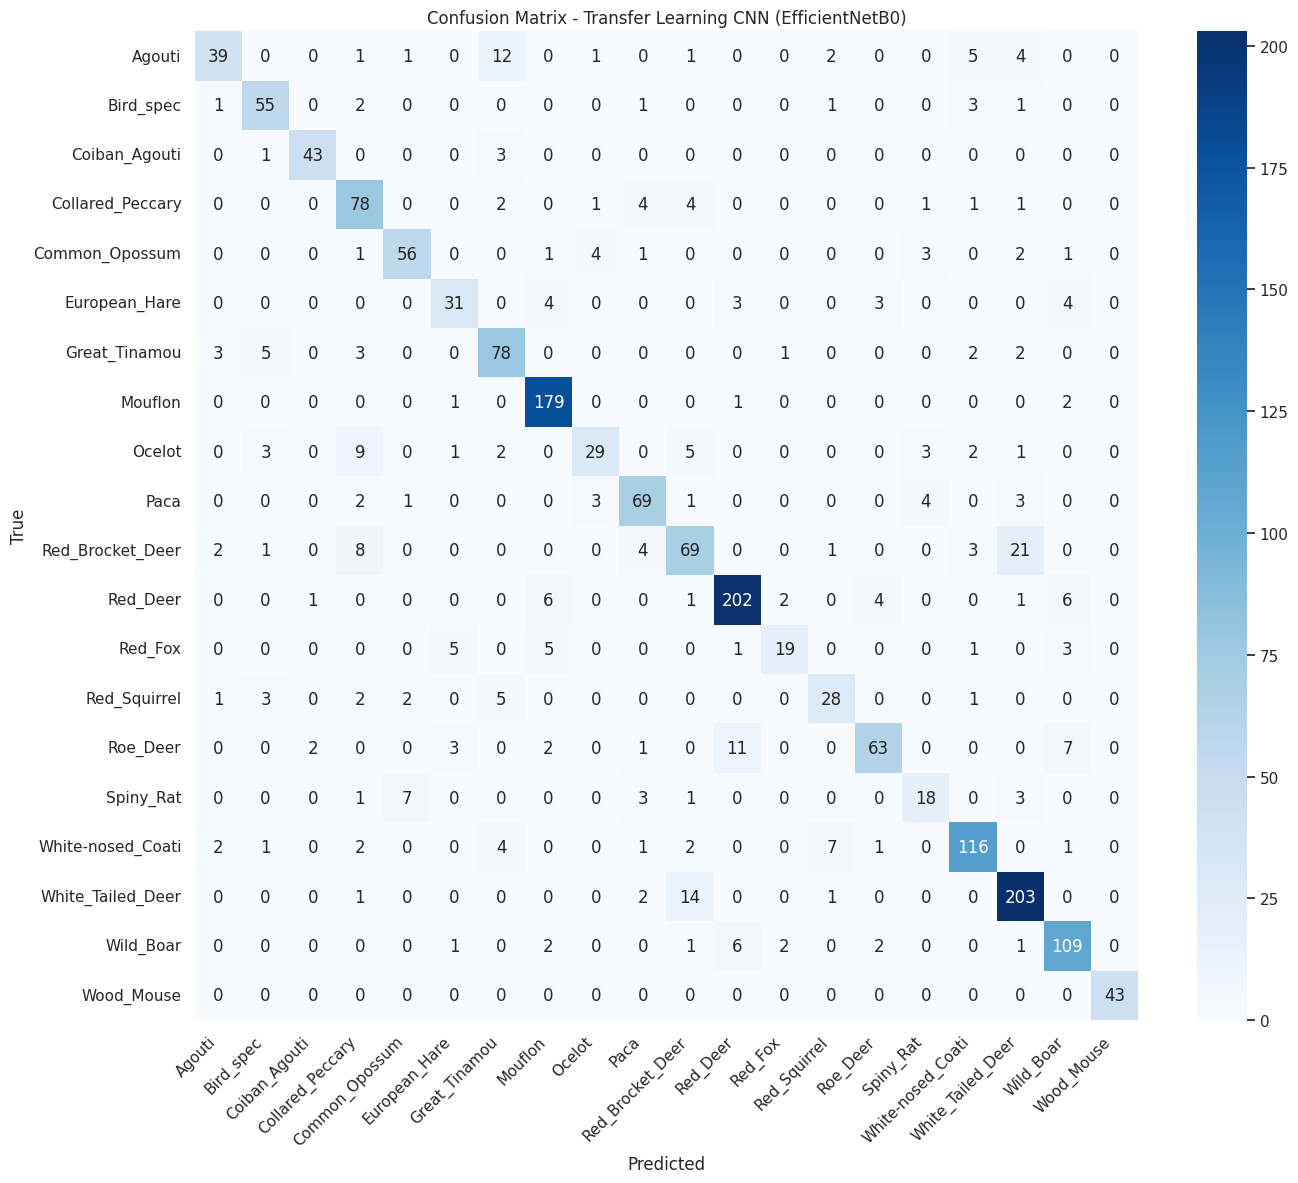


Transfer Learning CNN Classification Report:
                   precision    recall  f1-score   support

           Agouti       0.81      0.59      0.68        66
        Bird_spec       0.80      0.86      0.83        64
    Coiban_Agouti       0.93      0.91      0.92        47
 Collared_Peccary       0.71      0.85      0.77        92
   Common_Opossum       0.84      0.81      0.82        69
    European_Hare       0.74      0.69      0.71        45
    Great_Tinamou       0.74      0.83      0.78        94
          Mouflon       0.90      0.98      0.94       183
           Ocelot       0.76      0.53      0.62        55
             Paca       0.80      0.83      0.82        83
 Red_Brocket_Deer       0.70      0.63      0.66       109
         Red_Deer       0.90      0.91      0.90       223
          Red_Fox       0.79      0.56      0.66        34
     Red_Squirrel       0.70      0.67      0.68        42
         Roe_Deer       0.86      0.71      0.78        89
        S

In [26]:
# Transfer Learning CNN Confusion Matrix
transfer_y_true, transfer_y_pred = plot_tf_confusion_matrix(
    transfer_cnn_model, cnn_test_ds, label_encoder,
    title="Confusion Matrix - Transfer Learning CNN (EfficientNetB0)"
)

# Classification report
print("\nTransfer Learning CNN Classification Report:")
print("=" * 60)
print(classification_report(transfer_y_true, transfer_y_pred, target_names=label_encoder.classes_, zero_division=0))

In [27]:
# =============================================================================
# PYTORCH SETUP FOR ViT
# =============================================================================

import torch
import torch.nn as nn
import torch.optim as opti
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import ViTModel
from tqdm import tqdm

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✓ PyTorch version: {torch.__version__}")
print(f"✓ Device: {device}")
if torch.cuda.is_available():
    print(f"✓ GPU: {torch.cuda.get_device_name(0)}")

✓ PyTorch version: 2.9.0+cu126
✓ Device: cuda
✓ GPU: NVIDIA A100-SXM4-40GB


In [29]:
# Create PyTorch DataLoaders for ViT
# Split training data into train/val for ViT (70% train, 15% val, 15% test)
vit_train_files, vit_temp_files, vit_train_labels, vit_temp_labels, vit_train_bboxes, vit_temp_bboxes = train_test_split(
    filepaths, labels, bbox_array, test_size=0.3, random_state=RANDOM_SEED, stratify=labels
)

vit_val_files, vit_test_files, vit_val_labels, vit_test_labels, vit_val_bboxes, vit_test_bboxes = train_test_split(
    vit_temp_files, vit_temp_labels, vit_temp_bboxes, test_size=0.5, random_state=RANDOM_SEED, stratify=vit_temp_labels
)

# Create Datasets
vit_train_dataset = SerengetiDataset(vit_train_files, vit_train_labels, vit_train_bboxes, transform=vit_train_transform)
vit_val_dataset = SerengetiDataset(vit_val_files, vit_val_labels, vit_val_bboxes, transform=vit_val_transform)
vit_test_dataset = SerengetiDataset(vit_test_files, vit_test_labels, vit_test_bboxes, transform=vit_val_transform)

# Create DataLoaders
vit_train_loader = DataLoader(vit_train_dataset, batch_size=VIT_BATCH_SIZE, shuffle=True, num_workers=0)
vit_val_loader = DataLoader(vit_val_dataset, batch_size=VIT_BATCH_SIZE, shuffle=False, num_workers=0)
vit_test_loader = DataLoader(vit_test_dataset, batch_size=VIT_BATCH_SIZE, shuffle=False, num_workers=0)

print(f"✓ ViT Train: {len(vit_train_dataset)} | Val: {len(vit_val_dataset)} | Test: {len(vit_test_dataset)}")

# Verify bbox normalization
sample_img, sample_label, sample_bbox = vit_train_dataset[0]
print(f"✓ BBox Normalization Check:")
print(f"  Sample bbox (normalized): {sample_bbox.numpy()}")
print(f"  All values in [0,1] range: {(sample_bbox >= 0).all() and (sample_bbox <= 1).all()}")

✓ ViT Train: 6482 | Val: 1389 | Test: 1390
✓ BBox Normalization Check:
  Sample bbox (normalized): [0.48535156 0.4830729  0.58203125 0.546875  ]
  All values in [0,1] range: True


In [31]:
# =============================================================================
# VIT TRAINING FUNCTIONS
# =============================================================================

# Loss Functions
vit_criterion_class = nn.CrossEntropyLoss()
vit_criterion_bbox = nn.MSELoss()

# Optimizer
vit_optimizer = optim.AdamW(vit_model.parameters(), lr=VIT_LEARNING_RATE, weight_decay=0.01)

# Learning Rate Scheduler
vit_scheduler = optim.lr_scheduler.ReduceLROnPlateau(vit_optimizer, mode='min', factor=0.5, patience=5)


def vit_train_one_epoch(model, loader, optimizer, device):
    """Train ViT for one epoch."""
    model.train()
    total_loss, total_class_loss, total_bbox_loss = 0, 0, 0
    correct, total = 0, 0

    pbar = tqdm(loader, desc="Training")
    for images, labels, bboxes in pbar:
        images = images.to(device)
        labels = labels.to(device)
        bboxes = bboxes.to(device)

        optimizer.zero_grad()
        class_logits, bbox_pred = model(images)

        class_loss = vit_criterion_class(class_logits, labels)
        bbox_loss = vit_criterion_bbox(bbox_pred, bboxes)
        loss = class_loss + bbox_loss

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_class_loss += class_loss.item()
        total_bbox_loss += bbox_loss.item()

        _, predicted = class_logits.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100.*correct/total:.1f}%'})

    n_batches = len(loader)
    return {
        'loss': total_loss / n_batches,
        'class_loss': total_class_loss / n_batches,
        'bbox_loss': total_bbox_loss / n_batches,
        'accuracy': 100. * correct / total
    }


def vit_validate(model, loader, device):
    """Validate ViT model."""
    model.eval()
    total_loss, total_class_loss, total_bbox_loss = 0, 0, 0
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels, bboxes in loader:
            images = images.to(device)
            labels = labels.to(device)
            bboxes = bboxes.to(device)

            class_logits, bbox_pred = model(images)

            class_loss = vit_criterion_class(class_logits, labels)
            bbox_loss = vit_criterion_bbox(bbox_pred, bboxes)
            loss = class_loss + bbox_loss

            total_loss += loss.item()
            total_class_loss += class_loss.item()
            total_bbox_loss += bbox_loss.item()

            _, predicted = class_logits.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    n_batches = len(loader)
    return {
        'loss': total_loss / n_batches,
        'class_loss': total_class_loss / n_batches,
        'bbox_loss': total_bbox_loss / n_batches,
        'accuracy': 100. * correct / total
    }

print("✓ Training functions defined")

✓ Training functions defined


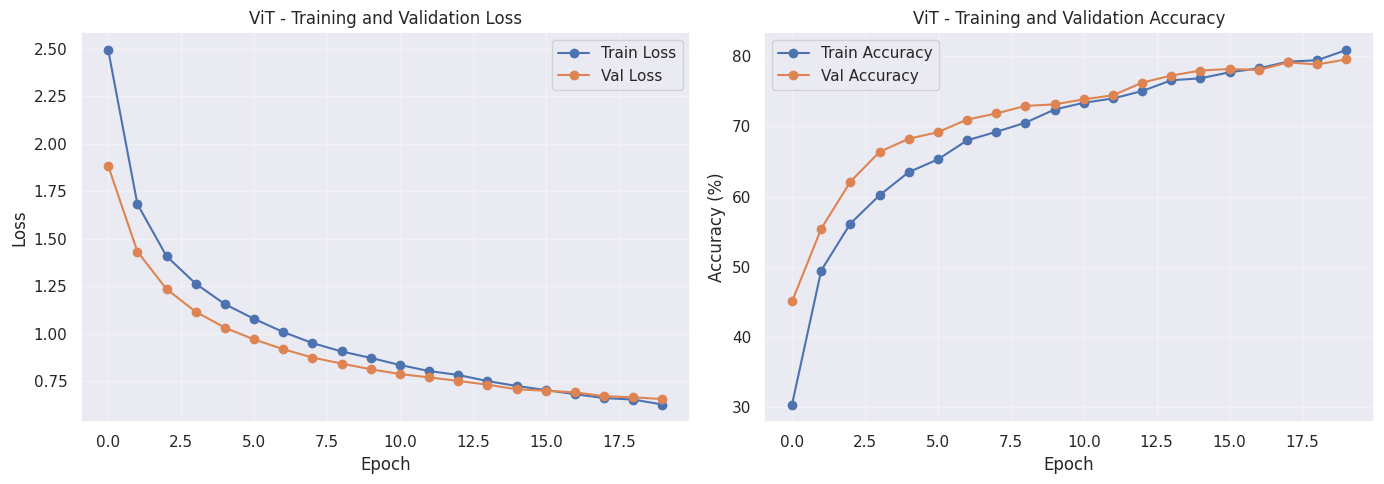

In [33]:
# Plot ViT learning curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(vit_history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(vit_history['val_loss'], label='Val Loss', marker='o')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('ViT - Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(vit_history['train_acc'], label='Train Accuracy', marker='o')
axes[1].plot(vit_history['val_acc'], label='Val Accuracy', marker='o')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('ViT - Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

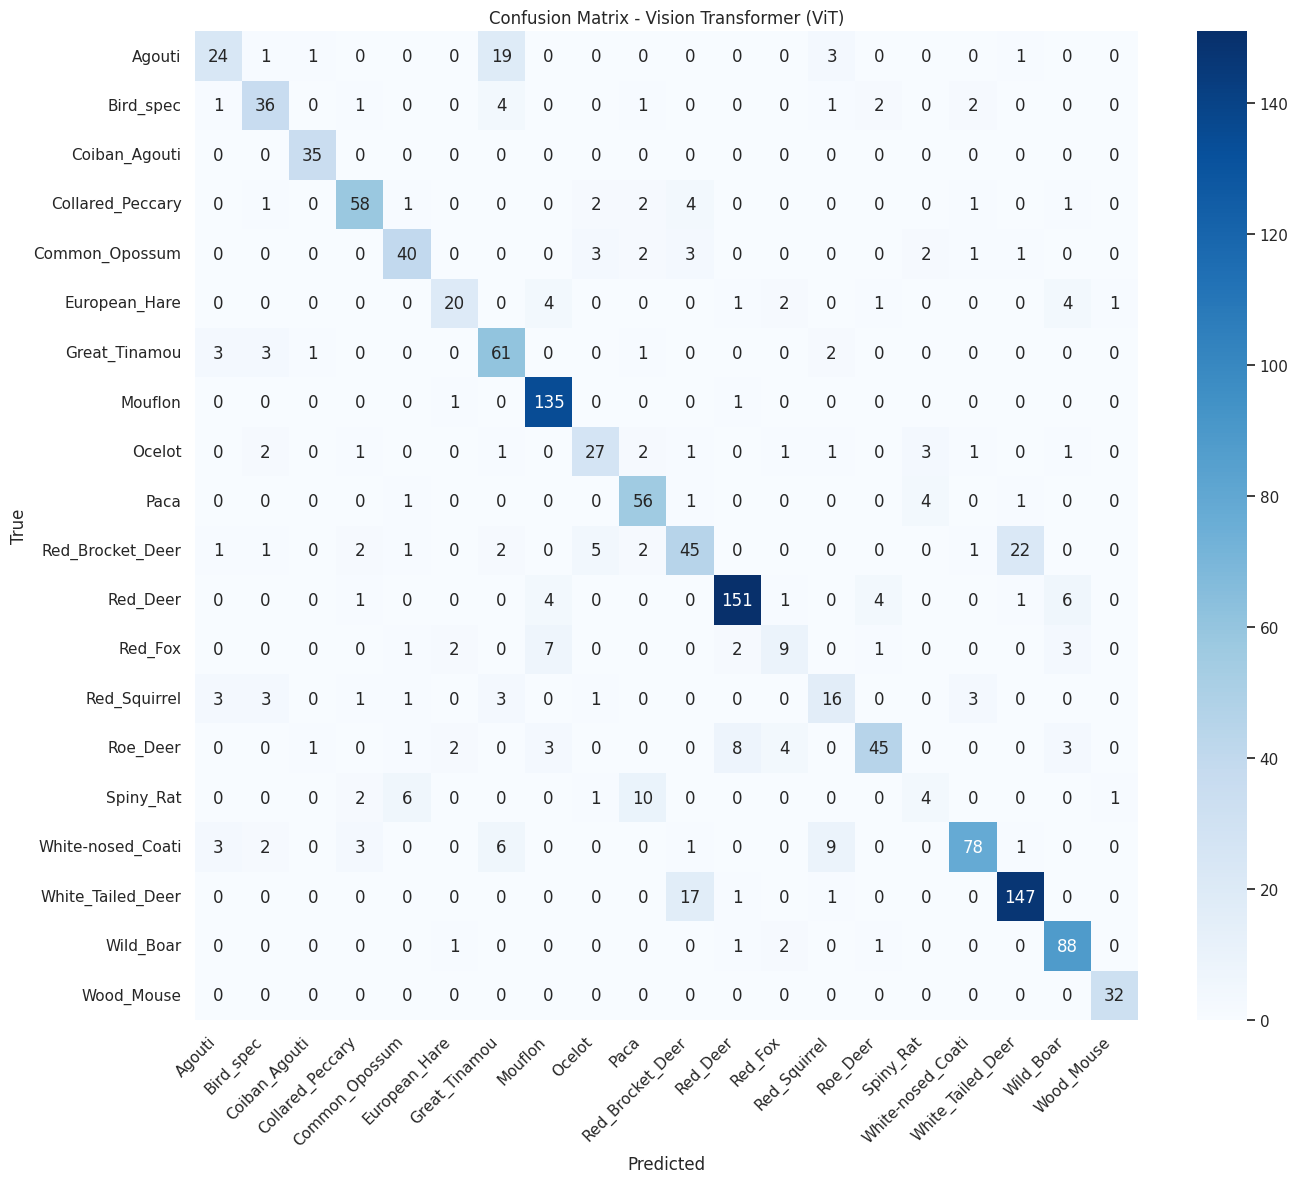


ViT Classification Report:
                   precision    recall  f1-score   support

           Agouti       0.69      0.49      0.57        49
        Bird_spec       0.73      0.75      0.74        48
    Coiban_Agouti       0.92      1.00      0.96        35
 Collared_Peccary       0.84      0.83      0.83        70
   Common_Opossum       0.77      0.77      0.77        52
    European_Hare       0.77      0.61      0.68        33
    Great_Tinamou       0.64      0.86      0.73        71
          Mouflon       0.88      0.99      0.93       137
           Ocelot       0.69      0.66      0.68        41
             Paca       0.74      0.89      0.81        63
 Red_Brocket_Deer       0.62      0.55      0.58        82
         Red_Deer       0.92      0.90      0.91       168
          Red_Fox       0.47      0.36      0.41        25
     Red_Squirrel       0.48      0.52      0.50        31
         Roe_Deer       0.83      0.67      0.74        67
        Spiny_Rat       0.3

In [35]:
# ViT Confusion Matrix
vit_cm = confusion_matrix(vit_test_labels, vit_test_preds)

plt.figure(figsize=(14, 12))
sns.heatmap(
    vit_cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Vision Transformer (ViT)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Classification report
print("\nViT Classification Report:")
print("=" * 60)
print(classification_report(vit_test_labels, vit_test_preds, target_names=label_encoder.classes_, zero_division=0))

---
## 9. Model Comparison

Comprehensive comparison of all three models across classification and bounding box regression metrics.

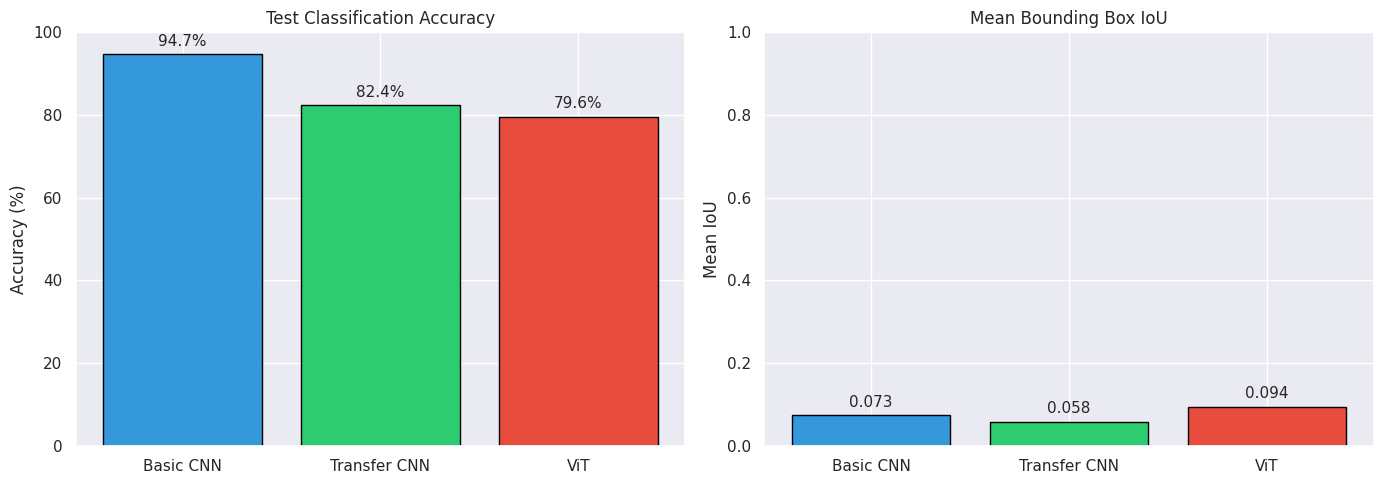

In [38]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

models = ['Basic CNN', 'Transfer CNN', 'ViT']
colors = ['#3498db', '#2ecc71', '#e74c3c']

# Classification Accuracy
accuracies = comparison_df['Test Accuracy (%)'].values
axes[0].bar(models, accuracies, color=colors, edgecolor='black')
axes[0].set_ylabel('Accuracy (%)')
axes[0].set_title('Test Classification Accuracy')
axes[0].set_ylim(0, 100)
for i, v in enumerate(accuracies):
    axes[0].text(i, v + 2, f'{v:.1f}%', ha='center', fontsize=11)

# Mean IoU
ious = comparison_df['Mean IoU'].values
axes[1].bar(models, ious, color=colors, edgecolor='black')
axes[1].set_ylabel('Mean IoU')
axes[1].set_title('Mean Bounding Box IoU')
axes[1].set_ylim(0, 1)
for i, v in enumerate(ious):
    axes[1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=11)

plt.tight_layout()
plt.show()

# 10. Conclusion

This project compared three very different modeling strategies—Basic CNN, Transfer Learning with EfficientNetB0, and a Vision Transformer (ViT)—for wildlife classification and bounding-box detection on the Serengeti dataset. Although each model approached the problem from a unique architectural perspective, their performance revealed patterns that help explain both their strengths and their practical limitations.

Overall, the Basic CNN emerged as the strongest performer in classification accuracy, despite being the simplest model. Both Transfer Learning and ViT showed steady improvement during training, but neither reached the Basic CNN’s accuracy under the constraints of our experiment. Importantly, this gap is not necessarily due to inferior model capacity. Rather, both advanced models trained for far fewer epochs because of the very long training time per epoch—especially the ViT. Given more computational budget, it is reasonable to expect that their performance would continue improving.

With smaller subsets of the dataset, all three models achieved similar levels of classification accuracy, which suggests that the additional modeling complexity did not translate into meaningful gains in this specific context. A likely explanation is the dataset itself: many images share highly similar backgrounds, since they are captured from a limited number of fixed camera locations. This consistency means that the models can learn to associate background cues with particular animals. When train/test splits are random, some of these background patterns inevitably appear in both sets, reducing the difficulty of the classification task. Simpler models, like the Basic CNN—benefit the most from this, since the task becomes closer to pattern recognition than true semantic understanding.

A similar phenomenon helps explain why the Transfer Learning CNN achieved the lowest Mean Bounding Box IoU, even though it was trained for only 20 total epochs. EfficientNetB0 was pretrained on ImageNet, where objects are usually centered and framed cleanly. In contrast, Serengeti animals often appear small, distant, and occluded in cluttered natural scenes. With limited fine-tuning time, the pretrained backbone cannot fully adapt to this distribution shift. Meanwhile, the Basic CNN—trained from scratch learns the dataset’s bounding-box patterns directly, giving it an advantage in localization.

Taken together, these observations highlight an important lesson for applied computer vision:
	•	Model complexity must align with both the dataset and the available compute budget.

Even though ViTs are state-of-the-art in many vision tasks, they are not automatically superior for every dataset—especially when computation is limited and the dataset contains strong environmental cues that simpler architectures can exploit effectively.